In [140]:
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(2)

%load_ext autoreload
%autoreload 2

In [141]:
def load_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) #number of points per class
    D = 2 #Dimension
    X = np.zeros((m,D)) # rows are examples
    Y = np.zeros((m,1),dtype = 'uint8') #label vectors
    a = 4 #maximum ray of the flower
    
    for j in range(2):
        ix = range(N * j, N*(j + 1))
        t = np.linspace(j * 3.12, (j + 1) * 3.12, N) + np.random.randn(N) * 0.2
        r = a*np.sin(4 * t) + np.random.randn(N) *0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T
    
    return X,Y

shapes of X and Y: (2, 400) (1, 400)
with 400 Training Examples


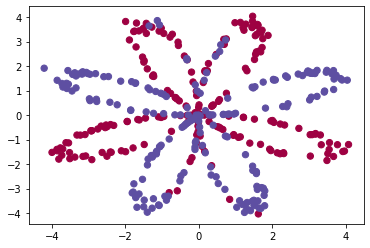

In [142]:
X, Y = load_dataset()
print("shapes of X and Y:", X.shape, Y.shape)
print("with %d Training Examples" % X.shape[1])

plt.scatter(X[0,:], X[1,:],c = Y, s = 40, cmap = plt.cm.Spectral)

### Simple Logistic Regression model

In [143]:
logClassifer = sklearn.linear_model.LogisticRegression().fit(X.T, Y.T.ravel())

In [144]:
#Decision Boundary of Logistic Model


def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


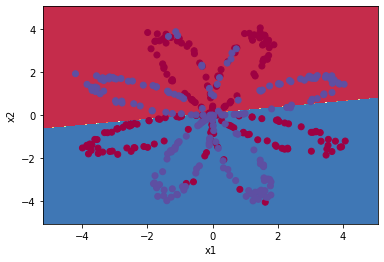

In [145]:
plot_decision_boundary(lambda x: logClassifer.predict(x), X, Y)

LR_predictions = logClassifer.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

### Nueral Network Model


<a name='4'></a>

**The model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$


$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$


#### 1. Define the Structure of NN

In [146]:
def layer_size(X,Y):
    
    n_x = X.shape[0]    #size of input layer
    n_y = Y.shape[0]    #size of output layer
    n_h = 4             #size of hidden layer
    
    return (n_x,n_h,n_y)

#### 2. Initialize the Parameters of the NN model

In [147]:
def parameter_initialization(n_x,n_h,n_y):
    np.random.seed(2)
    
    # 
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2= np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y,1))
    parameters = {"W1": W1,
                  "W2": W2,
                  "b1": b1,
                  "b2": b2}
    return parameters

#### 3. Forward Propagation

$$Z^{[1]} =  W^{[1]} X + b^{[1]}\tag{1}$$ 
$$A^{[1]} = \tanh(Z^{[1]})\tag{2}$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\tag{3}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{4}$$



In [148]:
def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

In [149]:
def forward_propagation(X,parameters):
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1,X)+ b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
        
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

#### 4.Cost
$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

In [150]:
def costfunction(A2,Y):
    m = Y.shape[1]
    
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2),(1-Y))
    cost = - 1/m* np.sum(logprobs) 
    cost = float(np.squeeze(cost))
    return cost


#### 5. Backpropagation, using cache computed in the forward propagation 



<img src="images/grad_summary.png" style="width:600px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: Backpropagation. Use the six equations on the right.</font></center></caption>

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

In [151]:
def back_propagation(params, cache, X , Y):
    
    m = X.shape[1]
    
    W1 = params['W1']
    W2 = params['W2']    
    A1 = cache["A1"]
    A2 = cache["A2"]    
    
    dZ2 = A2 - Y
    dW2 = 1/m* np.dot(dZ2,A1.T)
    db2 = 1/m * np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = np.dot(W2.T, dZ2) *(1 - np.power(A1, 2))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis = 1, keepdims = True)
    
    grads = {"dW1":dW1,
             "db1":db1,
             "dW2":dW2,
             "db2":db2}
    
    return grads

#### 6.Update Parameters
$\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ 

In [152]:
def update_params(params,grads,alpha = 1.2):
    
    W1 = params["W1"]
    W2 = params["W2"]
    b1 = params["b1"]
    b2 = params["b2"]
    
    dW1 = grads["dW1"]
    dW2 = grads["dW2"]
    db1 = grads["db1"]
    db2 = grads["db2"]
    
    W1 = W1 - alpha * dW1
    W2 = W2 - alpha * dW2    
    b1 = b1 - alpha * db1
    b2 = b2 - alpha * db2    
    
    params = {"W1":W1,
              "W2":W2,
              "b1":b1,
              "b2":b2}
    
    return params

### 7. Pack into a Neural Network

In [153]:
def nn_model(X,Y,n_h,num_iters= 10000,print_cost = False):
    
    #NN Strucuture
    np.random.seed(3)
    n_x = layer_size(X,Y)[0]
    n_y = layer_size(X,Y)[2]
    
    #Initialize the parameters
    params = parameter_initialization(n_x, n_h, n_y)
    
    #update the parameters, forward_propagation, backward_propagation
    for i in range(0, num_iters):
        A2,cache = forward_propagation(X, params)
        cost = costfunction(A2, Y)
        grads = back_propagation(params,cache,X,Y)
        params = update_params(params,grads,alpha = 1.2)
        
        if print_cost and i % 1000 == 0:
            print("cost after iteration %i: %f" % (i, cost))
            
    return params

### Prediction

$y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  

In [154]:
def predict(params, X):
    
    A2, cache = forward_propagation(X, params)
    predictions = (A2 > 0.5)
    
    return predictions

### Test the Model on Planar Dataset

cost after iteration 0: 0.693048
cost after iteration 1000: 0.288083
cost after iteration 2000: 0.254385
cost after iteration 3000: 0.233864
cost after iteration 4000: 0.226792
cost after iteration 5000: 0.222644
cost after iteration 6000: 0.219731
cost after iteration 7000: 0.217504
cost after iteration 8000: 0.219504
cost after iteration 9000: 0.218571


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

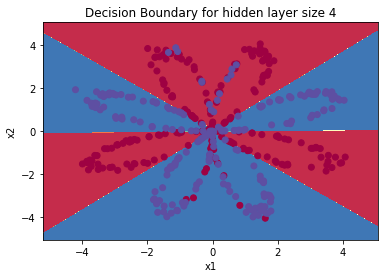

In [155]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iters = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [156]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 90%


### Tuning the hidden Layer Size

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.0 %
Accuracy for 50 hidden units: 90.75 %


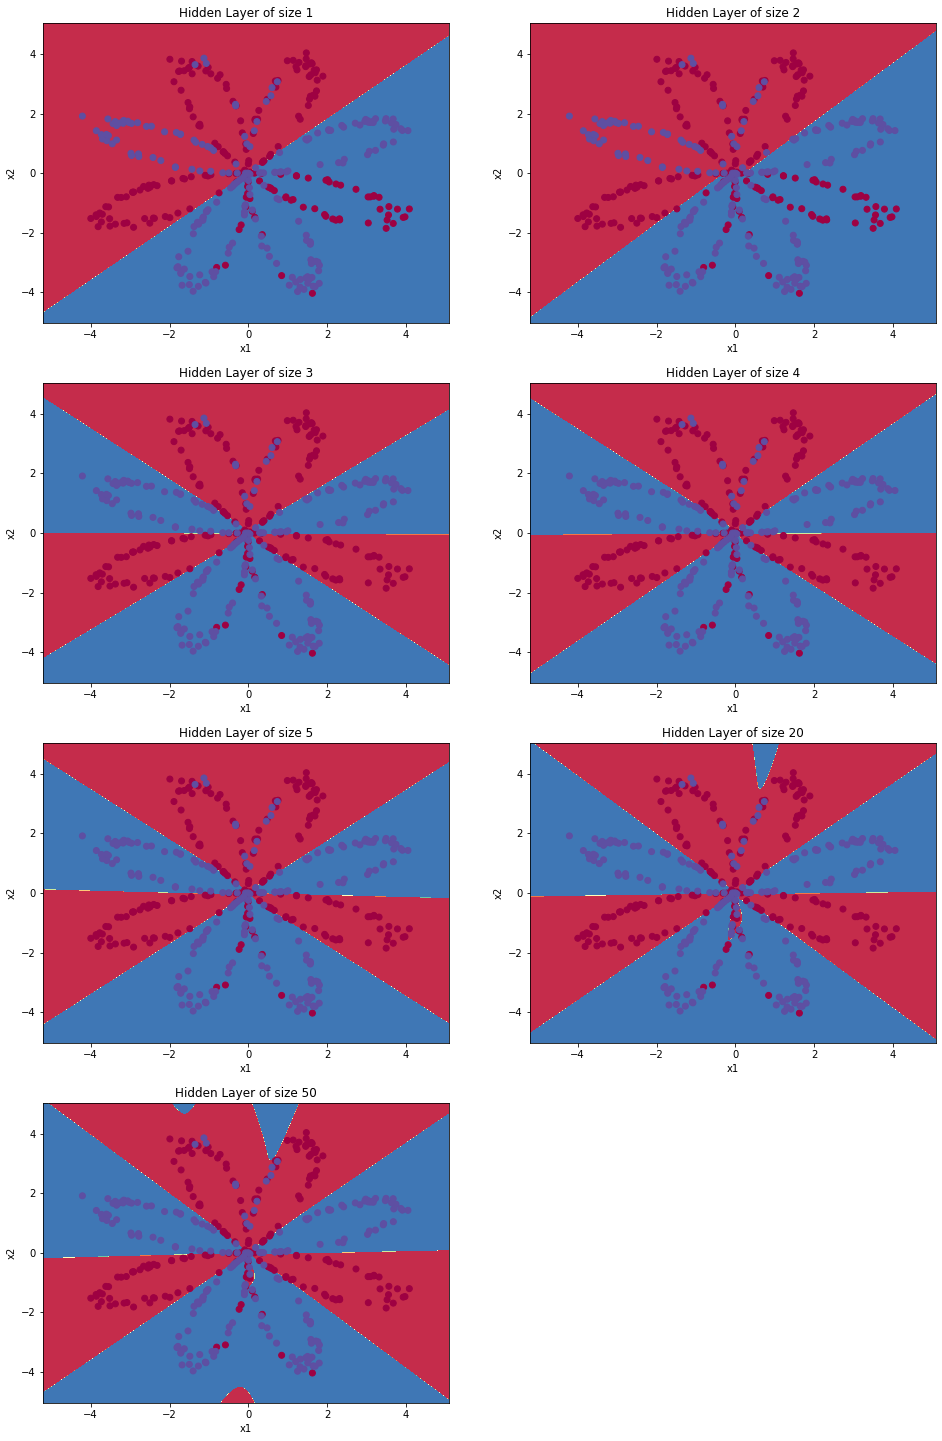

In [157]:
plt.figure(figsize = (16,32))
hidden_layer_sizes = [1,2,3,4,5,20,50]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5,2,i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    params = nn_model(X,Y,n_h,num_iters=5000)
    plot_decision_boundary(lambda x:predict(params,x.T), X, Y)
    predictions = predict(params, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

## With Relu Activiation

In [158]:
def Relu(X):
    y_hat = X * (X > 0)
    return y_hat

In [159]:
def forward_propagation(X,parameters):
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1,X)+ b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = Relu(Z2)
        
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

c:\users\howuseeit\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
c:\users\howuseeit\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Accuracy for 1 hidden units: 50.0 %
Accuracy for 2 hidden units: 65.5 %


c:\users\howuseeit\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Accuracy for 3 hidden units: 89.75 %
Accuracy for 4 hidden units: 89.25 %
Accuracy for 5 hidden units: 88.0 %
Accuracy for 20 hidden units: 88.5 %
Accuracy for 50 hidden units: 88.25 %


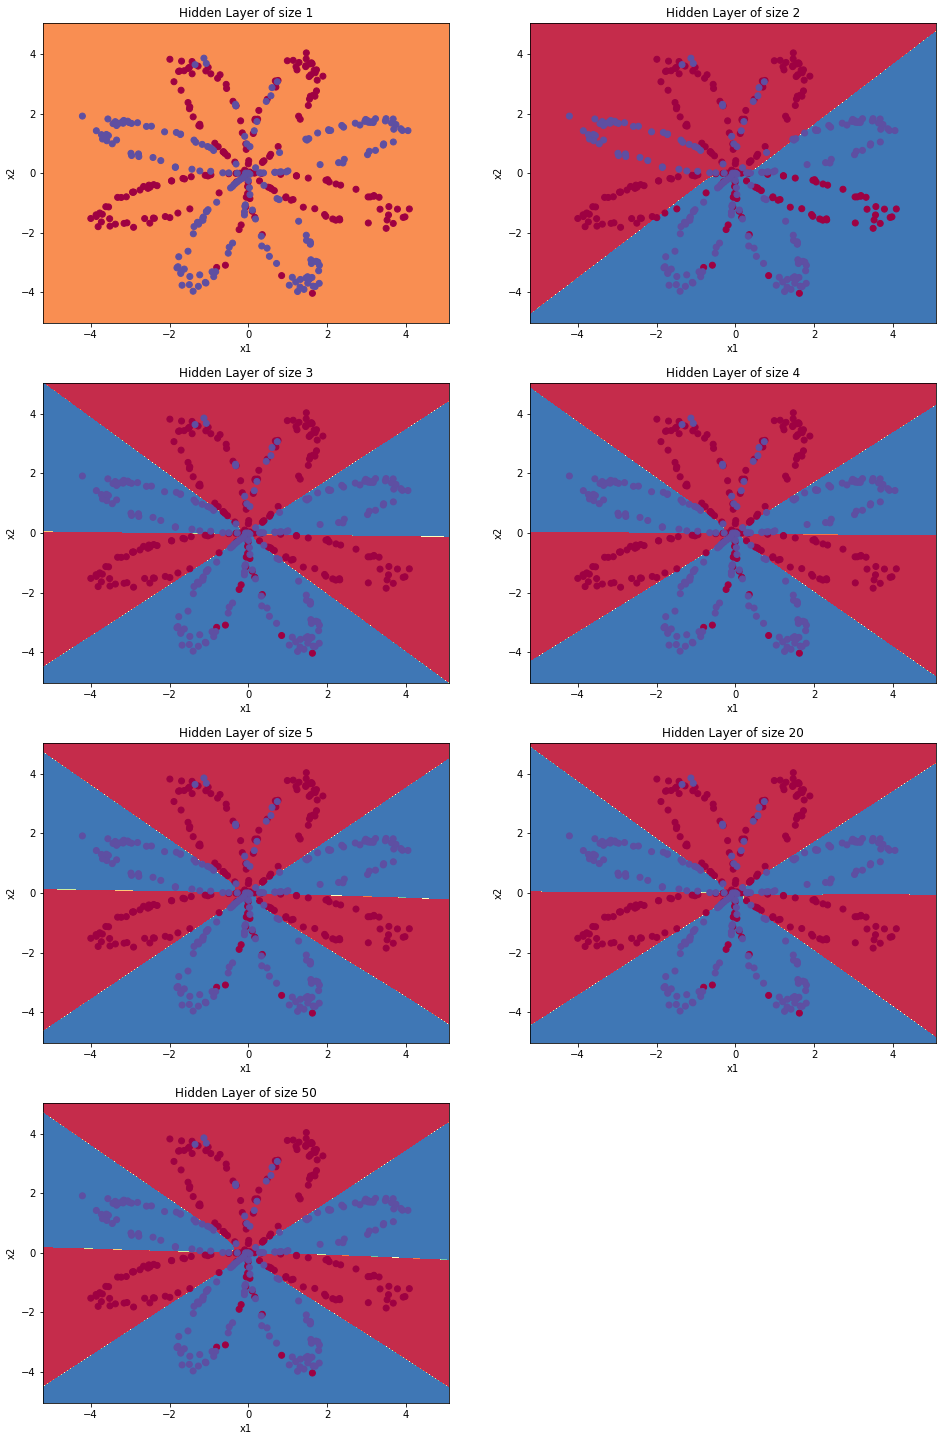

In [160]:
plt.figure(figsize = (16,32))
hidden_layer_sizes = [1,2,3,4,5,20,50]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5,2,i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    params = nn_model(X,Y,n_h,num_iters=5000)
    plot_decision_boundary(lambda x:predict(params,x.T), X, Y)
    predictions = predict(params, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

### With different Learing Rate

In [161]:
def nn_model(X,Y,n_h,num_iters= 10000,print_cost = False):
    
    #NN Strucuture
    np.random.seed(3)
    n_x = layer_size(X,Y)[0]
    n_y = layer_size(X,Y)[2]
    
    #Initialize the parameters
    params = parameter_initialization(n_x, n_h, n_y)
    
    #update the parameters, forward_propagation, backward_propagation
    for i in range(0, num_iters):
        A2,cache = forward_propagation(X, params)
        cost = costfunction(A2, Y)
        grads = back_propagation(params,cache,X,Y)
        params = update_params(params,grads,alpha = 1.5)
        
        if print_cost and i % 1000 == 0:
            print("cost after iteration %i: %f" % (i, cost))
            
    return params

c:\users\howuseeit\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
c:\users\howuseeit\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Accuracy for 1 hidden units: 57.49999999999999 %
Accuracy for 2 hidden units: 66.25 %


c:\users\howuseeit\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Accuracy for 3 hidden units: 86.75 %
Accuracy for 4 hidden units: 88.5 %
Accuracy for 5 hidden units: 79.0 %
Accuracy for 20 hidden units: 86.75 %
Accuracy for 50 hidden units: 89.0 %


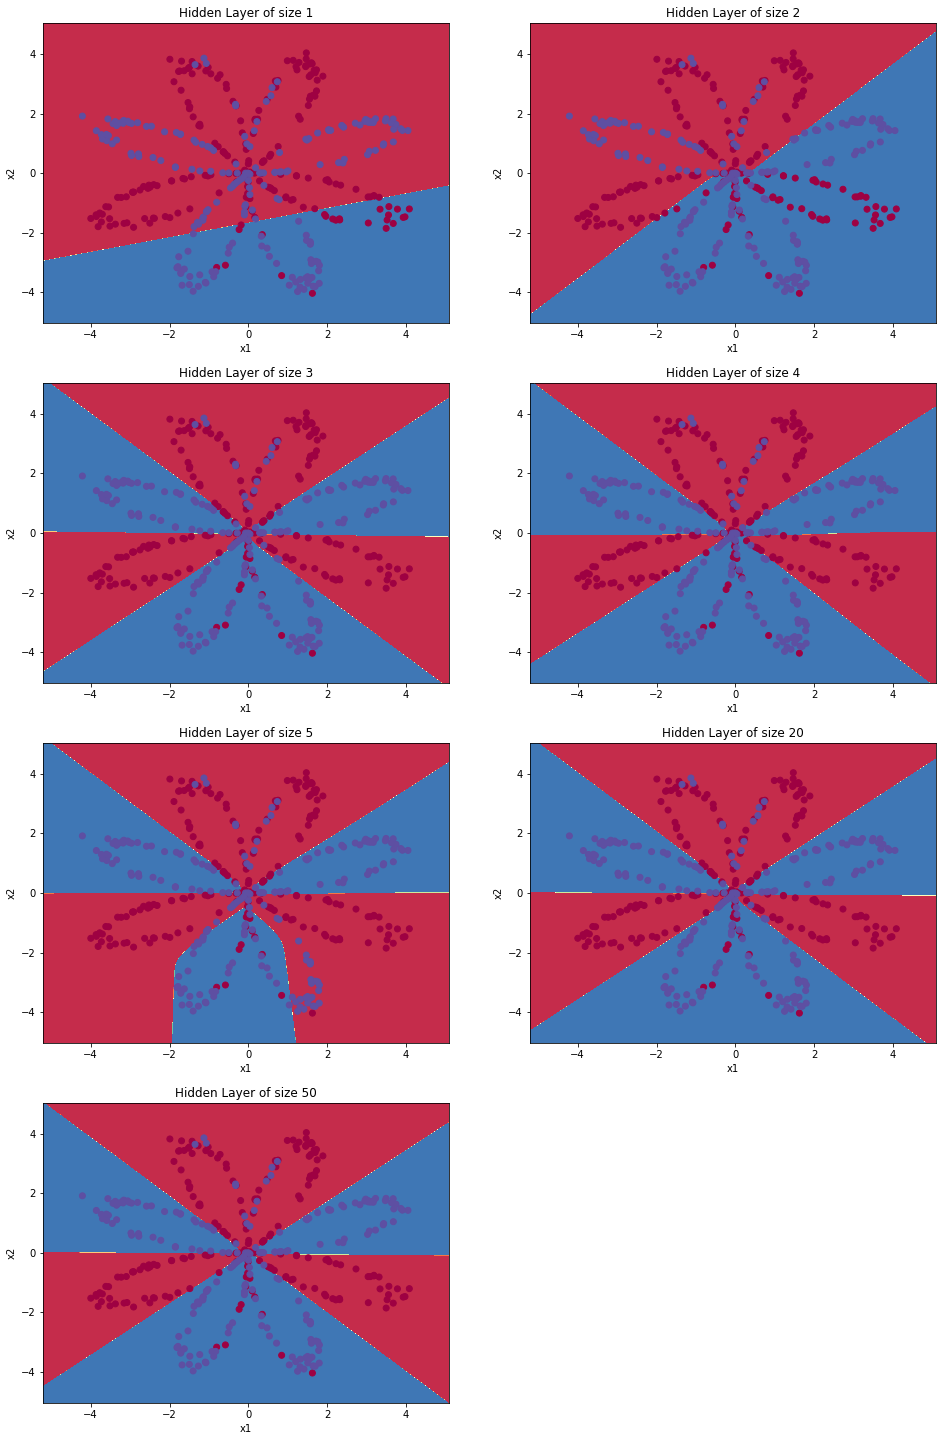

In [162]:
plt.figure(figsize = (16,32))
hidden_layer_sizes = [1,2,3,4,5,20,50]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5,2,i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    params = nn_model(X,Y,n_h,num_iters=5000)
    plot_decision_boundary(lambda x:predict(params,x.T), X, Y)
    predictions = predict(params, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

### Performance on the different dataset

In [163]:
def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

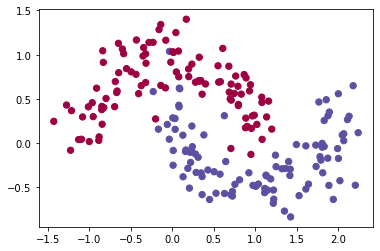

In [164]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

dataset = "noisy_moons"

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

c:\users\howuseeit\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
c:\users\howuseeit\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
c:\users\howuseeit\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Accuracy for 1 hidden units: 87.0 %
Accuracy for 2 hidden units: 87.0 %
Accuracy for 3 hidden units: 87.0 %
Accuracy for 4 hidden units: 97.5 %
Accuracy for 5 hidden units: 87.0 %
Accuracy for 20 hidden units: 96.0 %
Accuracy for 50 hidden units: 80.5 %


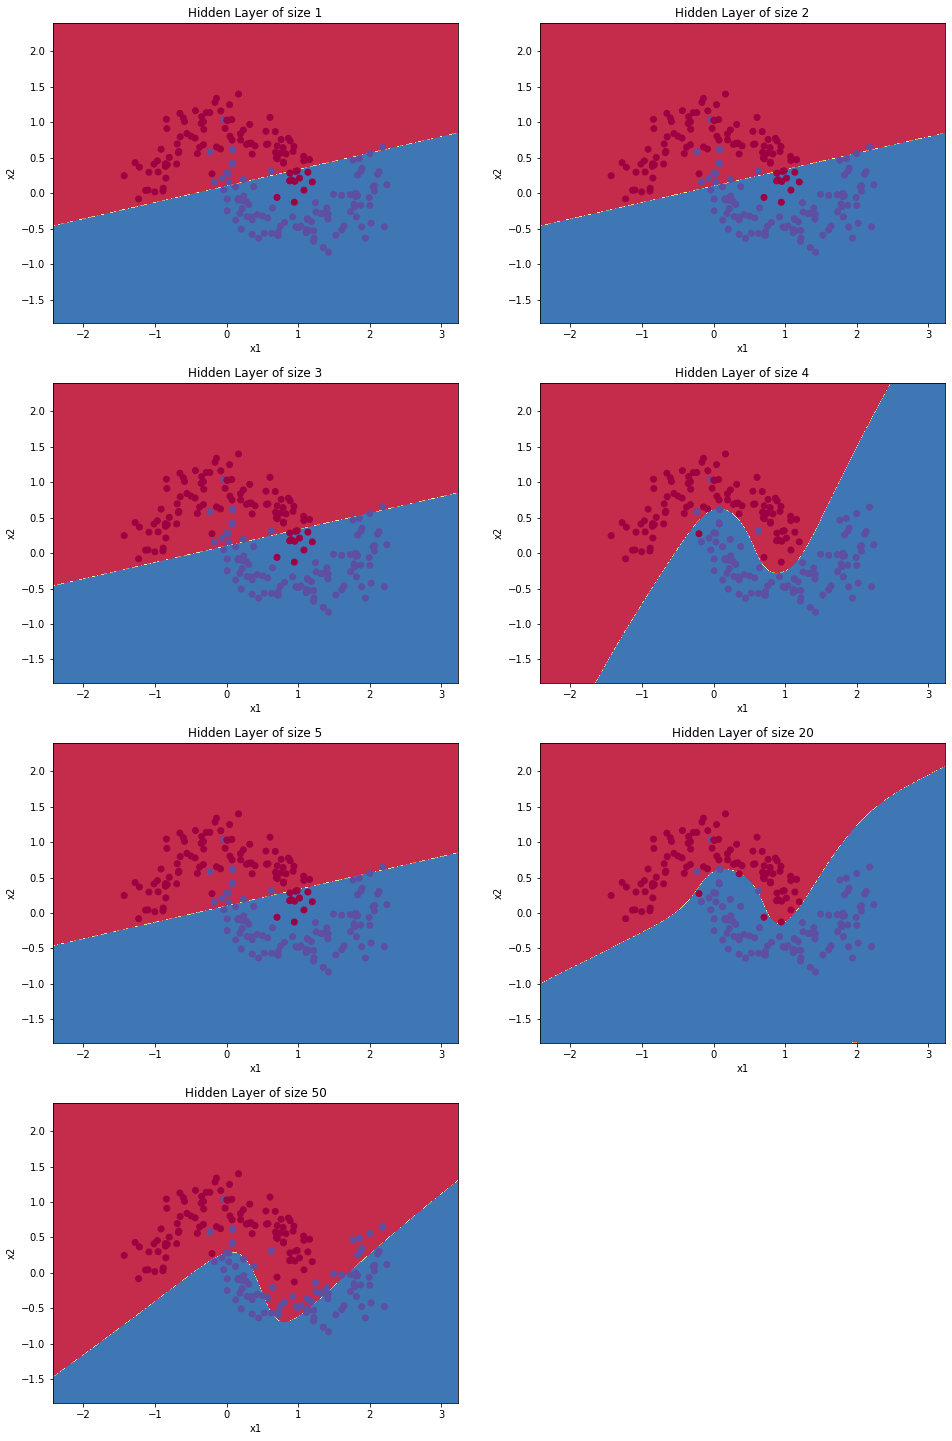

In [165]:
plt.figure(figsize = (16,32))
hidden_layer_sizes = [1,2,3,4,5,20,50]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5,2,i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    params = nn_model(X,Y,n_h,num_iters=5000)
    plot_decision_boundary(lambda x:predict(params,x.T), X, Y)
    predictions = predict(params, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))